# Step 1: Fetch Movie Data from API


In [1]:
import os
import json
import requests
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()

ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")

In [5]:
base_url = "https://api.themoviedb.org/3/movie/"

headers = {"accept": "application/json", "Authorization": f"Bearer {ACCESS_TOKEN}"}

movie_ids = [
    0, 
    299534,
    19995,
    140607,
    299536,
    597,
    135397,
    420818,
    24428,
    168259,
    99861,
    284054,
    12445,
    181808,
    330457,
    351286,
    109445,
    321612,
    260513,
]

movies = []

# Fetch movie data for each ID
for movie_id in movie_ids:
    url = f"{base_url}{movie_id}?append_to_response=credits"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        movies.append(response.json())
    else:
        print(f"Failed to fetch data for movie ID {movie_id}: {response.status_code}")

# Create dataframe
movies_df = pd.DataFrame(movies)
print(f"Fetched {len(movies_df)} movies successfully.")
movies_df.info()

Failed to fetch data for movie ID 0: 404
Fetched 18 movies successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18 non-null     bool   
 1   backdrop_path          18 non-null     object 
 2   belongs_to_collection  16 non-null     object 
 3   budget                 18 non-null     int64  
 4   genres                 18 non-null     object 
 5   homepage               18 non-null     object 
 6   id                     18 non-null     int64  
 7   imdb_id                18 non-null     object 
 8   origin_country         18 non-null     object 
 9   original_language      18 non-null     object 
 10  original_title         18 non-null     object 
 11  overview               18 non-null     object 
 12  popularity             18 non-null     float64
 13  poster_path            18 non-null     

# Step 2: Data Cleaning and Preprocessing


In [6]:
# Drop irrelevant columns
movies_df.drop(
    columns=[
        "adult",
        "imdb_id",
        "original_title",
        "video",
        "homepage",
        "backdrop_path",
    ],
    inplace=True,
)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  16 non-null     object 
 1   budget                 18 non-null     int64  
 2   genres                 18 non-null     object 
 3   id                     18 non-null     int64  
 4   origin_country         18 non-null     object 
 5   original_language      18 non-null     object 
 6   overview               18 non-null     object 
 7   popularity             18 non-null     float64
 8   poster_path            18 non-null     object 
 9   production_companies   18 non-null     object 
 10  production_countries   18 non-null     object 
 11  release_date           18 non-null     object 
 12  revenue                18 non-null     int64  
 13  runtime                18 non-null     int64  
 14  spoken_languages       18 non-null     object 
 15  status  

### Extract and clean key data points

In [7]:

# Extract name from collection
movies_df["belongs_to_collection"] = movies_df["belongs_to_collection"].apply(
    lambda x: x["name"] if isinstance(x, dict) and "name" in x else None
)

# Extract genre names
movies_df["genres"] = movies_df["genres"].apply(
    lambda x: "|".join([genre["name"] for genre in x])
)

# Extract spoken languages
movies_df["spoken_languages"] = movies_df["spoken_languages"].apply(
    lambda x: "|".join([lang["english_name"] for lang in x])
)

# Extract production countries
movies_df["production_countries"] = movies_df["production_countries"].apply(
    lambda x: "|".join([country["name"] for country in x])
)

# Extract production companies
movies_df["production_companies"] = movies_df["production_companies"].apply(
    lambda x: "|".join([company["name"] for company in x])
)

# Extract cast, directors, and their sizes
movies_df["cast"] = movies_df["credits"].apply(
    lambda x: "|".join([member["name"] for member in x["cast"]])
)
movies_df["cast_size"] = movies_df["credits"].apply(lambda x: len(x["cast"]))
movies_df["directors"] = movies_df["credits"].apply(
    lambda x: "|".join(
        [member["name"] for member in x["crew"] if member["job"] == "Director"]
    )
)
movies_df["crew_size"] = movies_df["credits"].apply(lambda x: len(x["crew"]))
movies_df.drop(columns=["credits"], inplace=True)


In [8]:

# Convert column data types
movies_df["budget"] = pd.to_numeric(movies_df["budget"], errors="coerce")
movies_df["id"] = pd.to_numeric(movies_df["id"], errors="coerce")
movies_df["popularity"] = pd.to_numeric(movies_df["popularity"], errors="coerce")
movies_df["revenue"] = pd.to_numeric(movies_df["revenue"], errors="coerce")
movies_df["runtime"] = pd.to_numeric(movies_df["runtime"], errors="coerce")
movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors="coerce")



In [ ]:
# Replace unrealistic values with NaN
movies_df.loc[movies_df["budget"] <= 0, "budget"] = pd.NA
movies_df.loc[movies_df["revenue"] <= 0, "revenue"] = pd.NA
movies_df.loc[movies_df["runtime"] <= 0, "runtime"] = pd.NA

In [10]:
# convert budget and revenue to millions
movies_df["budget_musd"] = movies_df["budget"] / 1_000_000
movies_df["revenue_musd"] = movies_df["revenue"] / 1_000_000
movies_df.drop(columns=["budget", "revenue"], inplace=True)
movies_df.loc[movies_df["vote_count"] == 0, "vote_average"] = pd.NA

# replace text placeholders with NaN
known_placeholders = ["", "-", "N/A", "No Data", "No overview", "Unknown", "None"]
movies_df["overview"] = movies_df["overview"].replace(known_placeholders, pd.NA)
movies_df["tagline"] = movies_df["tagline"].replace(known_placeholders, pd.NA)


In [11]:
# remove duplicates
movies_df.drop_duplicates(subset=["id"], keep="first", inplace=True)

# drop unknown id or title
movies_df.dropna(subset=["id", "title"], inplace=True)

# keep row with at least 10 non-NaN values
movies_df = movies_df[movies_df.notna().sum(axis=1) >= 10]

# filter only movies released then drop status
movies_df = movies_df[movies_df["status"] == "Released"]
movies_df.drop(columns=["status"], inplace=True)


In [12]:

# Reorder columns
ordered_columns = [
    "id",
    "title",
    "tagline",
    "release_date",
    "genres",
    "belongs_to_collection",
    "original_language",
    "budget_musd",
    "revenue_musd",
    "production_companies",
    "production_countries",
    "vote_count",
    "vote_average",
    "popularity",
    "runtime",
    "overview",
    "spoken_languages",
    "poster_path",
    "cast",
    "cast_size",
    "directors",
    "crew_size",
]

movies_df = movies_df[ordered_columns]
movies_df.reset_index(drop=True, inplace=True)
movies_df.to_csv("cleaned_movies_data.csv", index=False)
movies_df.head(1)

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,vote_average,popularity,runtime,overview,spoken_languages,poster_path,cast,cast_size,directors,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,8.238,13.839,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,105,Joe Russo|Anthony Russo,607


# Step 3: KPI Implementation & Analysis


In [13]:
# ranking function
def rank_movies(
    df, metric, ascending=False, number_of_results=10, min_budget=None, min_votes=None
):

    data = df.copy()

    if min_budget is not None:
        data = data[data["budget_musd"] >= min_budget]
    if min_votes is not None:
        data = data[data["vote_count"] >= min_votes]

    # derived metrics
    if metric == "profit":
        data["profit"] = data["revenue_musd"] - data["budget_musd"]
    elif metric == "ROI":
        data["ROI"] = data["revenue_musd"] / data["budget_musd"]

    ranked = data.sort_values(by=metric, ascending=ascending)

    return ranked.head(number_of_results)


# Highest revenue
ranked_by_revenue = rank_movies(movies_df, metric="revenue_musd", ascending=False)
print("HIGHEST REVENUE", ranked_by_revenue[["title", "revenue_musd"]])

# Highest budget
ranked_by_budget = rank_movies(movies_df, metric="budget_musd", ascending=False)
print("HIGHEST BUDGET", ranked_by_budget[["title", "budget_musd"]])

# Highest profit
ranked_by_profit = rank_movies(movies_df, metric="profit", ascending=False)
print("HIGHEST PROFIT", ranked_by_profit[["title", "profit"]])

# Lowest profit
ranked_by_lowest_profit = rank_movies(movies_df, metric="profit", ascending=True)
print("LOWEST PROFIT", ranked_by_lowest_profit[["title", "profit"]])

# Highest ROI
ranked_by_roi = rank_movies(
    movies_df, metric="ROI", ascending=False, min_budget=10
)
print("HIGHEST ROI", ranked_by_roi[["title", "ROI"]])

# Lowest ROI
ranked_by_lowest_roi = rank_movies(
    movies_df, metric="ROI", ascending=True, min_budget=10
)
print("LOWEST ROI", ranked_by_lowest_roi[["title", "ROI"]])

# Most voted movies
ranked_by_votes = rank_movies(movies_df, metric="vote_count", ascending=False)
print("MOST VOTED", ranked_by_votes[["title", "vote_count"]])

# Highest rated movies
ranked_by_rating = rank_movies(
    movies_df, metric="vote_average", ascending=False, min_votes=10
)
print("HIGHEST RATED", ranked_by_rating[["title", "vote_average"]])

# Lowest rated movies
ranked_by_lowest_rating = rank_movies(
    movies_df, metric="vote_average", ascending=True, min_votes=10
)
print("LOWEST RATED", ranked_by_lowest_rating[["title", "vote_average"]])

# Most popular movies
ranked_by_popularity = rank_movies(movies_df, metric="popularity", ascending=False)
print("MOST POPULAR", ranked_by_popularity[["title", "popularity"]])

HIGHEST REVENUE                            title  revenue_musd
1                         Avatar   2923.706026
0              Avengers: Endgame   2799.439100
4                        Titanic   2264.162353
2   Star Wars: The Force Awakens   2068.223624
3         Avengers: Infinity War   2052.415039
5                 Jurassic World   1671.537444
6                  The Lion King   1662.020819
7                   The Avengers   1518.815515
8                      Furious 7   1515.400000
13                     Frozen II   1453.683476
HIGHEST BUDGET                            title  budget_musd
0              Avengers: Endgame        356.0
3         Avengers: Infinity War        300.0
12      Star Wars: The Last Jedi        300.0
6                  The Lion King        260.0
2   Star Wars: The Force Awakens        245.0
1                         Avatar        237.0
9        Avengers: Age of Ultron        235.0
7                   The Avengers        220.0
10                 Black Panther      

### Franchise vs. Standalone Movie Performance


In [6]:
# Separate franchise and standalone movies
franchise_movies = movies_df[movies_df["belongs_to_collection"].notna()]
standalone_movies = movies_df[movies_df["belongs_to_collection"].isna()]

In [7]:
# comparisons

# revenue means
franchise_mean_revenue = franchise_movies["revenue_musd"].mean()
standalone_mean_revenue = standalone_movies["revenue_musd"].mean()

# rois
franchise_mean_roi = (
    franchise_movies["revenue_musd"] / franchise_movies["budget_musd"]
).mean()
standalone_mean_roi = (
    standalone_movies["revenue_musd"] / standalone_movies["budget_musd"]
).mean()

# budget means
franchise_mean_budget = franchise_movies["budget_musd"].mean()
standalone_mean_budget = standalone_movies["budget_musd"].mean()

# popularity means
franchise_mean_popularity = franchise_movies["popularity"].mean()
standalone_mean_popularity = standalone_movies["popularity"].mean()

# rating means
franchise_mean_rating = franchise_movies["vote_average"].mean()
standalone_mean_rating = standalone_movies["vote_average"].mean()

pd.DataFrame(
    {
        "Metric": [
            "Mean Revenue",
            "Mean ROI",
            "Mean Budget",
            "Mean Popularity",
            "Mean Rating",
        ],
        "Franchise Movies": [
            franchise_mean_revenue,
            franchise_mean_roi,
            franchise_mean_budget,
            franchise_mean_popularity,
            franchise_mean_rating,
        ],
        "Standalone Movies": [
            standalone_mean_revenue,
            standalone_mean_roi,
            standalone_mean_budget,
            standalone_mean_popularity,
            standalone_mean_rating,
        ],
    }
)

,Metric,Franchise Movies,Standalone Movies
0,Mean Revenue,1682.668411,1765.139159
1,Mean ROI,7.994610,9.617018
2,Mean Budget,218.000000,180.000000
3,Mean Popularity,14.988431,21.143950
4,Mean Rating,7.386062,7.436000


### Most Successful Franchises & Directors


In [8]:
# Most successful franchises
grouped_franchises = franchise_movies.groupby("belongs_to_collection")
franchise_performance = grouped_franchises.agg(
    {
        "id": "count",
        "budget_musd": ["sum", "mean"],
        "revenue_musd": ["sum", "mean"],
        "vote_average": "mean",
    }
)
franchise_performance.columns = [
    "Total Movies",
    "Total Budget",
    "Total Revenue",
    "Mean Budget",
    "Mean Revenue",
    "Mean Rating",
]
franchise_performance.sort_values(by=["Total Movies", "Total Budget", "Total Revenue"], ascending=False)

,Total Movies,Total Budget,Total Revenue,Mean Budget,Mean Revenue,Mean Rating
belongs_to_collection,,,,,,
The Avengers Collection,4,1111.0,277.75,7776.073348,1944.018337,7.90175
Star Wars Collection,2,545.0,272.50,3400.922454,1700.461227,7.02750
Jurassic Park Collection,2,320.0,160.00,2982.006481,1491.003241,6.60000
Frozen Collection,2,300.0,150.00,2727.902485,1363.951242,7.24500
The Lion King (Reboot) Collection,1,260.0,260.00,1662.020819,1662.020819,7.10300
Avatar Collection,1,237.0,237.00,2923.706026,2923.706026,7.60000
Black Panther Collection,1,200.0,200.00,1349.926083,1349.926083,7.36600
The Incredibles Collection,1,200.0,200.00,1243.225667,1243.225667,7.45600
The Fast and the Furious Collection,1,190.0,190.00,1515.400000,1515.400000,7.20000


In [9]:
# Most Successful Directors
directors = movies_df["directors"].str.split("|").explode()
movies_with_directors = movies_df.loc[directors.index]
director_performance = movies_with_directors.groupby(directors).agg(
    {
        "id": "count",
        "revenue_musd": "sum",
        "vote_average": "mean",
    }
)
director_performance.columns = [
    "Total Movies",
    "Total Revenue",
    "Mean Rating",
]
director_performance.sort_values(by=["Total Movies", "Total Revenue"], ascending=False)

,Total Movies,Total Revenue,Mean Rating
directors,,,
James Cameron,2,5187.868379,7.7515
Anthony Russo,2,4851.854139,8.2370
Joe Russo,2,4851.854139,8.2370
Joss Whedon,2,2924.219209,7.5665
Chris Buck,2,2727.902485,7.2450
Jennifer Lee,2,2727.902485,7.2450
J.J. Abrams,1,2068.223624,7.2550
Colin Trevorrow,1,1671.537444,6.7000
Jon Favreau,1,1662.020819,7.1030


# Step 4: Data Visualizations

### 1. Revenue vs. Budget Trends

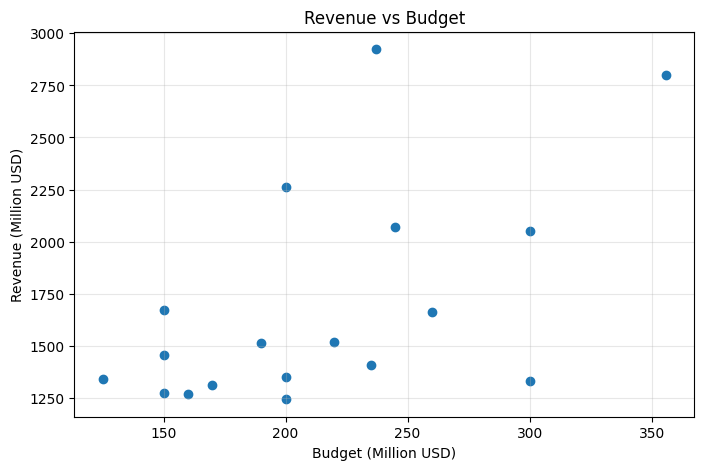

In [27]:
# Revenue vs Budget Scatter Plot
revenue = movies_df['revenue_musd']
budget = movies_df['budget_musd']

plt.figure(figsize=(8, 5))
plt.scatter(budget, revenue)
plt.xlabel('Budget (Million USD)')
plt.ylabel('Revenue (Million USD)')
plt.title('Revenue vs Budget')
plt.grid(True, alpha=0.3)
plt.show()


### 2. ROI Distribution by Genre

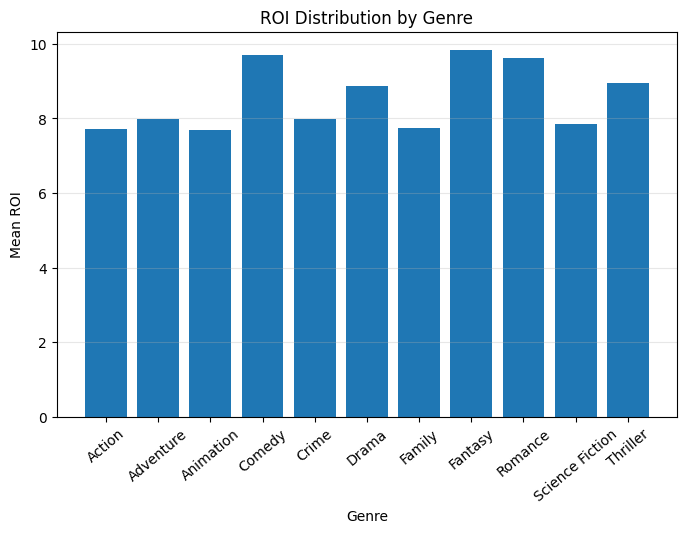

In [40]:
# Calculate ROI for all movies
movies_df['ROI'] = movies_df['revenue_musd'] / movies_df['budget_musd']

genre_roi_df = movies_df.assign(Genre=movies_df['genres'].str.split('|')).explode('Genre')
genre_avg_roi = genre_roi_df.groupby('Genre')['ROI'].mean()

# Plot ROI by Genre
plt.figure(figsize=(8, 5))
plt.bar(genre_avg_roi.index, genre_avg_roi.values)

plt.xlabel('Genre')
plt.ylabel('Mean ROI')
plt.title('ROI Distribution by Genre')
plt.xticks(rotation=40)
plt.grid(True, axis='y', alpha=0.3)
plt.show()


### 3. Popularity vs. Rating

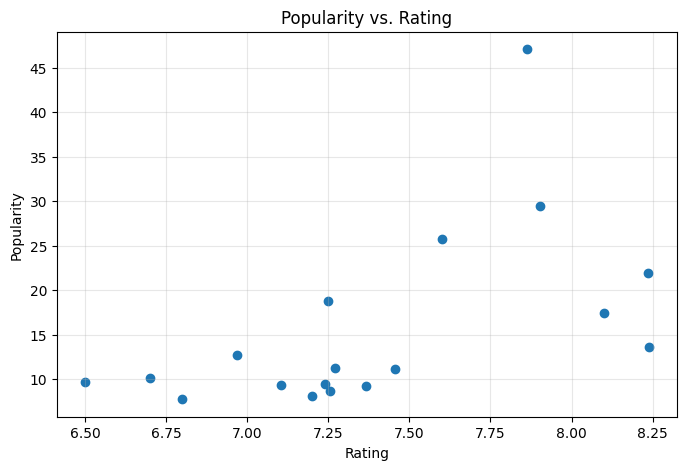

In [44]:
# Popularity vs Rating Scatter Plot
plt.figure(figsize=(8, 5))
scatter = plt.scatter(movies_df['vote_average'], movies_df['popularity'])

plt.xlabel('Rating')
plt.ylabel('Popularity')
plt.title('Popularity vs. Rating',)
plt.grid(True, alpha=0.3)
plt.show()


### 4. Yearly Trends in Box Office Performance

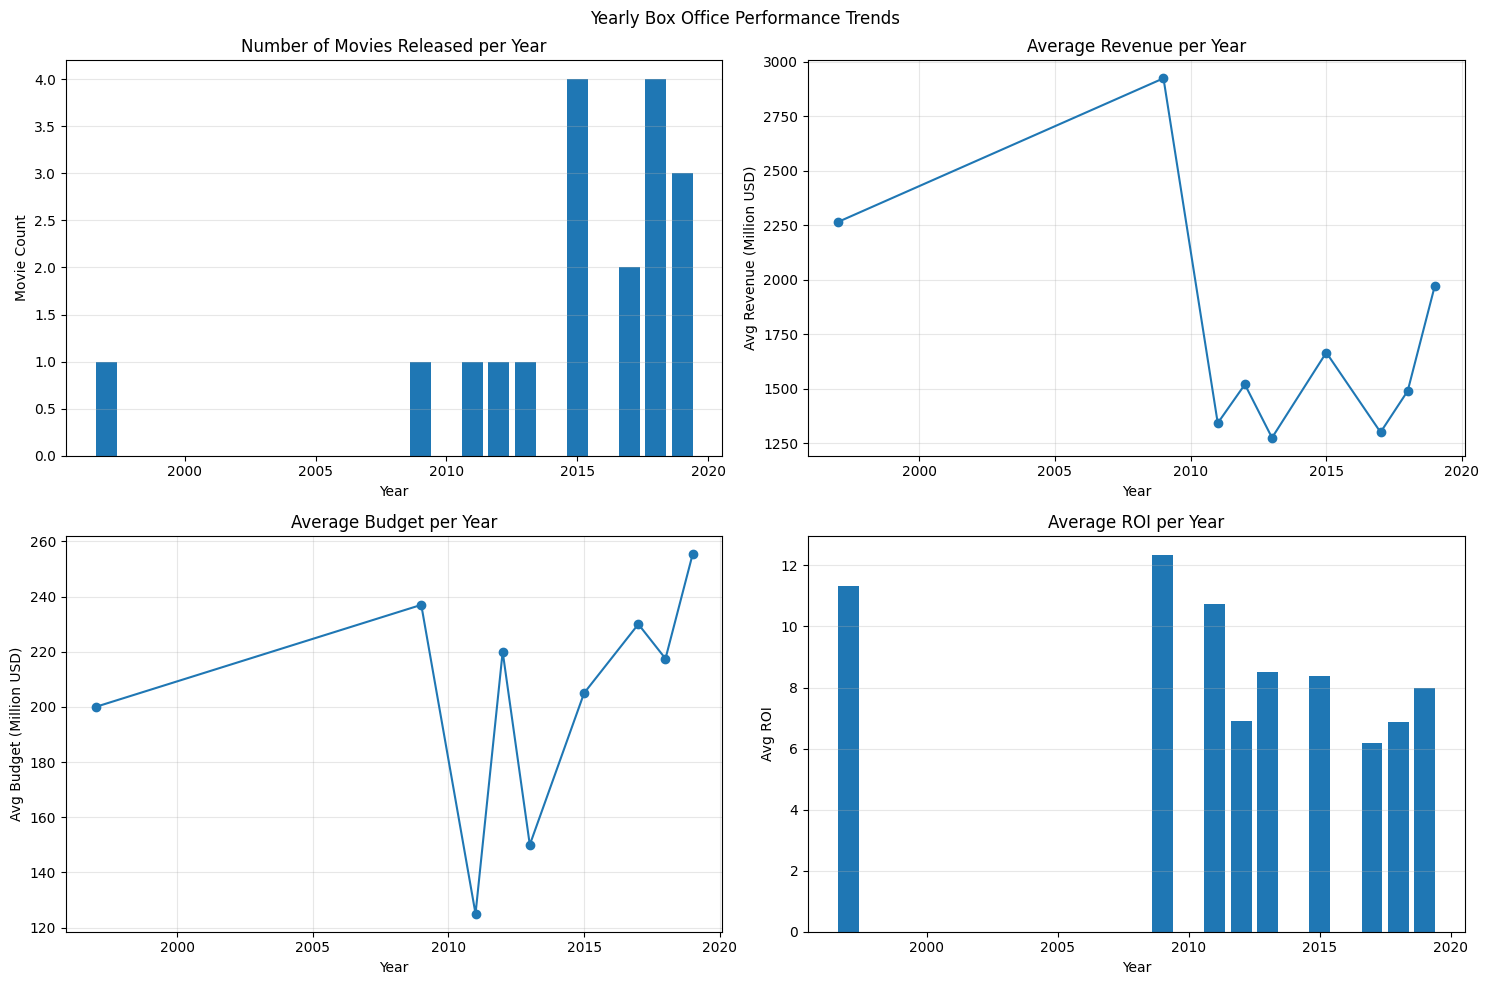


Yearly Statistics Summary:


,Movie Count,Mean Revenue,Mean Budget,Mean ROI
release_year,,,,
1997,1,2264.162353,200.000000,11.320812
2009,1,2923.706026,237.000000,12.336312
2011,1,1341.511219,125.000000,10.732090
2012,1,1518.815515,220.000000,6.903707
2013,1,1274.219009,150.000000,8.494793
2015,4,1665.141190,205.000000,8.385386
2017,2,1299.407397,230.000000,6.177777
2018,4,1489.008957,217.500000,6.878946
2019,3,1971.714465,255.333333,7.982401


In [60]:
# Extract year from release date
movies_df['release_year'] = movies_df['release_date'].dt.year

# Group by year and calculate metrics
yearly_stats = movies_df.groupby('release_year').agg({
    'revenue_musd': ['count', 'mean'],
    'budget_musd': 'mean',
    'ROI': 'mean'
})

yearly_stats.columns = ['Movie Count', 'Mean Revenue', 'Mean Budget', 'Mean ROI']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Yearly Box Office Performance Trends')

# Movie Count per Year
axes[0, 0].bar(yearly_stats.index, yearly_stats['Movie Count'])
axes[0, 0].set_title('Number of Movies Released per Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Movie Count')
axes[0, 0].grid(True, axis='y', alpha=0.3)

# Average Revenue per Year
axes[0, 1].plot(yearly_stats.index, yearly_stats['Mean Revenue'], marker='o')
axes[0, 1].set_title('Average Revenue per Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Avg Revenue (Million USD)')
axes[0, 1].grid(True, alpha=0.3)

# Average Budget per Year
axes[1, 0].plot(yearly_stats.index, yearly_stats['Mean Budget'], marker='o')
axes[1, 0].set_title('Average Budget per Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Avg Budget (Million USD)')
axes[1, 0].grid(True, alpha=0.3)

# Average ROI per Year
axes[1, 1].bar(yearly_stats.index, yearly_stats['Mean ROI'])
axes[1, 1].set_title('Average ROI per Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Avg ROI')
axes[1, 1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nYearly Statistics Summary:")
yearly_stats

### 5. Franchise vs. Standalone Success Comparison

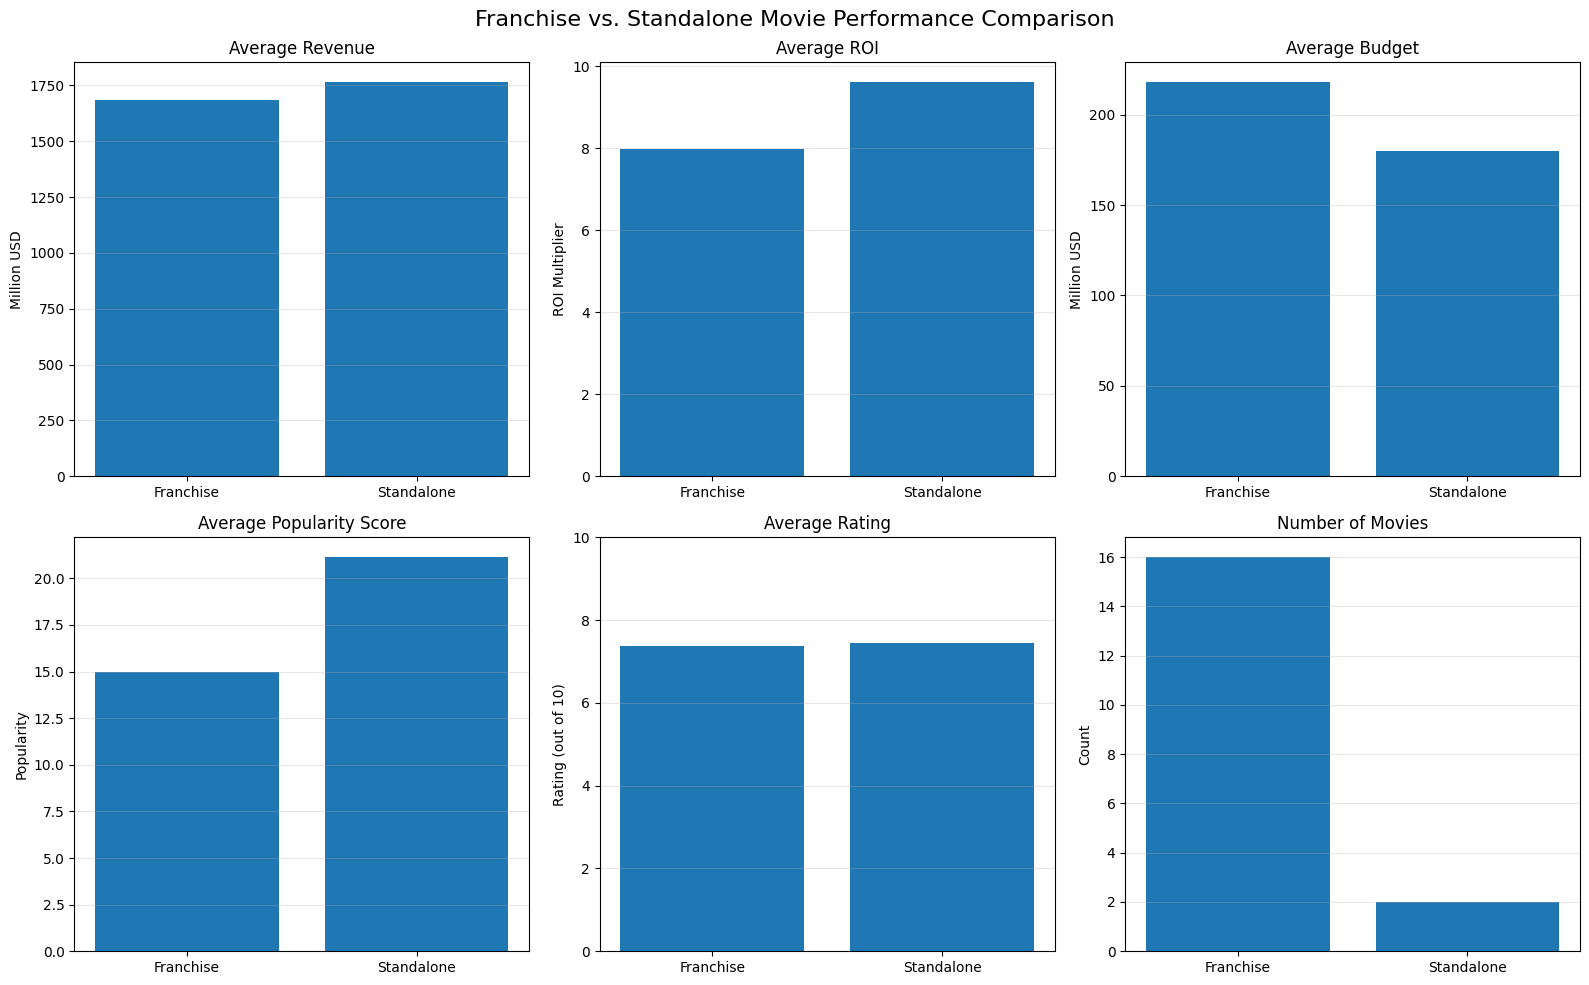

In [61]:
# Prepare comparison data
comparison_metrics = {
    'Mean Revenue': [franchise_mean_revenue, standalone_mean_revenue],
    'Mean ROI': [franchise_mean_roi, standalone_mean_roi],
    'Mean Budget': [franchise_mean_budget, standalone_mean_budget],
    'Mean Popularity': [franchise_mean_popularity, standalone_mean_popularity],
    'Mean Rating': [franchise_mean_rating, standalone_mean_rating]
}

categories = ['Franchise', 'Standalone']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Franchise vs. Standalone Movie Performance Comparison', fontsize=16)

# Plot 1: Mean Revenue
axes[0, 0].bar(categories, comparison_metrics['Mean Revenue'])
axes[0, 0].set_title('Average Revenue')
axes[0, 0].set_ylabel('Million USD')
axes[0, 0].grid(True, axis='y', alpha=0.3)


# Plot 2: Mean ROI
axes[0, 1].bar(categories, comparison_metrics['Mean ROI'])
axes[0, 1].set_title('Average ROI')
axes[0, 1].set_ylabel('ROI Multiplier')
axes[0, 1].grid(True, axis='y', alpha=0.3)


# Plot 3: Mean Budget
axes[0, 2].bar(categories, comparison_metrics['Mean Budget'])
axes[0, 2].set_title('Average Budget')
axes[0, 2].set_ylabel('Million USD')
axes[0, 2].grid(True, axis='y', alpha=0.3)


# Plot 4: Mean Popularity
axes[1, 0].bar(categories, comparison_metrics['Mean Popularity'])
axes[1, 0].set_title('Average Popularity Score')
axes[1, 0].set_ylabel('Popularity')
axes[1, 0].grid(True, axis='y', alpha=0.3)


# Plot 5: Mean Rating
axes[1, 1].bar(categories, comparison_metrics['Mean Rating'])
axes[1, 1].set_title('Average Rating')
axes[1, 1].set_ylabel('Rating (out of 10)')
axes[1, 1].set_ylim(0, 10)
axes[1, 1].grid(True, axis='y', alpha=0.3)

# Plot 6: Movie Count Comparison
movie_counts = [len(franchise_movies), len(standalone_movies)]
axes[1, 2].bar(categories, movie_counts)
axes[1, 2].set_title('Number of Movies')
axes[1, 2].set_ylabel('Count')
axes[1, 2].grid(True, axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

# summary table